# Denoising autoencoder for CIFAR dataset(s)

Every once in a while we come across an image from our shelf that we like, but sometimes that image is stained by coffee, markers or simply time. What can we do if we want the original image back, without those smears?

What can help us is called exactly like title suggests: denoising autoencoder (DAE later in this article).
But what exactly is this denoising autoencoder?

Let's start with autoencoder. Autoencoder is a neural network that consists of 2 parts: encoder and decoder. Exemplary image of such a network can be seen below.

![Autoencoder](images/Autoencoder_structure.png)
Image from wikipedia

Encoders job is to reduce dimensionality of our data (just like PCA). That data is then recreated by decoder. The most basic autoencoder is trained by comparing original data put into encoder's input and comparing it with decoders output. For DAE we put noisy data into encoder's input and compare decoder's output with clean data. For some tasks we train the whole autoencoder and later only use encoder's part to get rid of unnecessary variables. But here we will use both parts of the network.

For this short article we've decided to try to train DAE on CIFAR100 dataset and check how well it denoises images from CIFAR10 dataset. Deep learning library of our choice for this task is Keras.


### Part 1: Loading dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100, cifar10

Then we load CIFAR100 dataset, more about it and CIFAR10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html). Probably the most important fact is none of the images of CIFAR100 can be found in CIFAR10 dataset and vice versa.

We don't load labels, because we don't care about them at all.

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar100.load_data(label_mode='fine')

Next step: convert data to floats 0-1.

In [3]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

Now we need to produce noisy data. To do that we add gaussian noise with mean=0 and std=0.1 and then clip values back to 0-1. Mean=0 noise makes some parts of the image darker and some lighter after addition.

In [4]:
def add_noise_and_clip_data(data):
    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
    data = data + noise
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

Quick check if everything is alright.

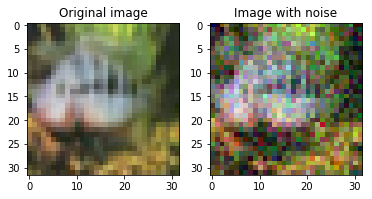

In [5]:
idx = 4
plt.subplot(1,2,1)
plt.imshow(train_data_clean[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

As you can see the noise substantially distorts the image.

### Part2: Defining architecture
Now we define building blocks of our DAE: convolutional block and deconvolutional block.

Convolutional block consists of 3 operations: 2D convolution, batch normalization and ReLu activation. We use strides=2 to downsample data going through the network.

Deconvolutional block also consists of 3 operations: 2D transposed convolution, batch normalization and also ReLu activation. Here strides=2 is used to upsample the data.

In [6]:
def conv_block(x, filters, kernel_size, strides=2):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

Our model architecture is inspired by [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/):
* 4 convolutional blocks with downsampling
* 1 convolutional block without downsampling
* 4 deconvolutional blocks with upsampling, interleaving concatenations
* 1 final deconvolution that recreates image size (32, 32, 3)
* 1 activation layer with sigmoid that scales values to 0-1.

Of course we encourage you to try your own archs, something like [DenseNet's skip connections](http://openaccess.thecvf.com/content_ICCV_2017/papers/Tong_Image_Super-Resolution_Using_ICCV_2017_paper.pdf) may perform well in our task.

In [7]:
def denoising_autoencoder():
    den_inputs = Input(shape=(32, 32, 3), name='dae_input')
    conv_block1 = conv_block(den_inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3, 1)

    deconv_block1 = deconv_block(conv_block5, 256, 3)
    merge1 = Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = deconv_block(merge1, 128, 3)
    merge2 = Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = deconv_block(merge2, 64, 3)
    merge3 = Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = deconv_block(merge3, 32, 3)

    final_deconv = Conv2DTranspose(filters=3,
                        kernel_size=3,
                        padding='same')(deconv_block4)

    den_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
    
    return Model(den_inputs, den_outputs, name='dae')

### Part 3: Training model
Now we compile the model using mean squared error as our loss and Adam as optimizer. ModelCheckpoint callback saves currently best model during training.

And finally we train the model for 40 epochs. Using batch_size=128 best val_loss is around 0.199.

Note: If you don't want to train the model by yourself we provide our best model from this training.

In [8]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
        train_data_clean,
        validation_data=(test_data_noisy, test_data_clean),
        epochs=40,
        batch_size=128,
        callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
49792/50000 [============================>.] - ETA: 0s - loss: 0.6628
Epoch 00001: val_loss improved from inf to 0.65164, saving model to best_model.h5
50000/50000 [==============================] - 14s 277us/step - loss: 0.6612 - val_loss: 0.6516
Epoch 2/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.3283
Epoch 00002: val_loss improved from 0.65164 to 0.30991, saving model to best_model.h5
50000/50000 [==============================] - 12s 232us/step - loss: 0.3281 - val_loss: 0.3099
Epoch 3/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.2993
Epoch 00003: val_loss did not improve from 0.30991
50000/50000 [==============================] - 11s 215us/step - loss: 0.2991 - val_loss: 0.3231
Epoch 4/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.2923
Epoch 00004: val_loss improved from 0.30991 to 0.27997, saving model to best_model.h5
50000/50000 [====================

Epoch 35/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.1985
Epoch 00035: val_loss improved from 0.20078 to 0.19878, saving model to best_model.h5
50000/50000 [==============================] - 11s 222us/step - loss: 0.1984 - val_loss: 0.1988
Epoch 36/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.1965
Epoch 00036: val_loss did not improve from 0.19878
50000/50000 [==============================] - 11s 228us/step - loss: 0.1964 - val_loss: 0.2048
Epoch 37/40
49792/50000 [============================>.] - ETA: 0s - loss: 0.1958
Epoch 00037: val_loss did not improve from 0.19878
50000/50000 [==============================] - 11s 225us/step - loss: 0.1956 - val_loss: 0.2005
Epoch 38/40
49920/50000 [============================>.] - ETA: 0s - loss: 0.1945
Epoch 00038: val_loss did not improve from 0.19878
50000/50000 [==============================] - 11s 216us/step - loss: 0.1944 - val_loss: 0.2000
Epoch 39/40
49920/50000 [========================

### Part 4: Interpreting results
Now we load our best model weights and try to predict (denoise) our CIFAR100 test data to visualize how well our DAE performs. After all loss number doesn't mean much if that's all we see.

Note: if you didn't train the model by yourself change `'best_model.h5'` to `'pretrained_model/best_model.h5'`.

In [9]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(test_data_noisy)

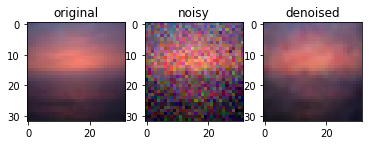

In [10]:
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

As can be seen DAE performs pretty well considering that added noise is brutal for the original image.

Now we will calculate mean squared error of the whole CIFAR100 test set. First we will calculate mse between our clean data and data with added noise. Next we check how well our DAE denoised the data.

In [11]:
def mse(data_1, data_2):
    return np.square(np.subtract(data_1, data_2)).mean()

noisy_clean_mse = mse(test_data_clean, test_data_noisy)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)
noisy_clean_mse, denoised_clean_mse

(0.0091120318424328, 0.0015556107)

As you can see our DAE decreased the noise around 6x (by ~83%).

### Part5: Testing our DAE on CIFAR10

As previously we load the data, only images.

In [12]:
(cifar10_train, _), (cifar10_test, _) = cifar10.load_data()

Convert images to floats and add noise.

In [13]:
cifar10_train = cifar10_train.astype('float32') / 255.
cifar10_test = cifar10_test.astype('float32') / 255.
cifar10_train_noisy = add_noise_and_clip_data(cifar10_train)
cifar10_test_noisy = add_noise_and_clip_data(cifar10_test)

And now we can denoise these images.

In [14]:
cifar10_test_denoised = dae.predict(cifar10_test_noisy)

And just like before we plot our results.

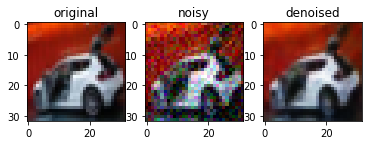

In [15]:
idx = 6
plt.subplot(1,3,1)
plt.imshow(cifar10_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(cifar10_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(cifar10_test_denoised[idx])
plt.title('denoised')
plt.show()

Not bad, our image is definitely more recognizable.

In [18]:
clean_noisy = mse(cifar10_test, cifar10_test_noisy)
clean_denoised = mse(cifar10_test, cifar10_test_denoised)
clean_noisy, clean_denoised

(0.009305541238191785, 0.001531884)

Seeing the number we can tell that our DAE worked pretty much as well on CIFAR10 as on CIFAR100. Images in both datasets aren't that different after all and image resolution is small.

### Conclusion
DAE fulfilled its task. After training on CIFAR100 it denoised CIFAR10 images without problems and without substantial drop of quality.